This is implementation of autoender architecture 

Load libs

In [2]:
from sklearn.model_selection import train_test_split
from file_utils import get_file_names_from_folder
#from image_utils import load_images
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from patchify import patchify 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Conv2DTranspose
from tensorflow.keras import Model, layers
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
plt.rcParams['figure.figsize'] = [15, 6]

2023-04-02 20:30:09.929335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load data

Set params of net and data

In [3]:
INPUT_IMAGE_SIZE = (64, 64)
BATCH_SIZE = 100
EPOTHS = 15

get paths for ground true images and for noise images

In [6]:
gt_images = []
noisy_images = []
#gt_images = load_images(gt_images, size=INPUT_IMAGE_SIZE)
#noisy_images = load_images(noisy_images, size=INPUT_IMAGE_SIZE)
file_names = get_file_names_from_folder('data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages',  mask = '*.JPG*')
file_names.sort()
for image_path in file_names:
    if image_path.split('/')[-1].endswith('mean.JPG'):
        gt_images.append(image_path)
    else:
        noisy_images.append(image_path)

# gt_images_set = load_images(gt_images, size=INPUT_IMAGE_SIZE)
# noisy_images_set = load_images(noisy_images, size=INPUT_IMAGE_SIZE)

file_names = get_file_names_from_folder('data/SIDD_Small/')
file_names.sort()
print(len(file_names))
# due to memory limit I read only 30 images from SIDD dataset
file_names = file_names[:30]
#
for image_path in file_names:
    if image_path.split('/')[-1].startswith('GT'):
        gt_images.append(image_path)
    else:
        noisy_images.append(image_path)
print(len(gt_images))
print(len(noisy_images))


320
115
115


In [5]:
%%time
def load_images(gt_images, noisy_images, size=(128,128)):
    gt_pacthes = np.array([])
    noise_pacthes = np.array([])
    x = 0
    for gt_path, noise_path in zip(gt_images, noisy_images):
        x = x +1
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        gt_img = gt_img/255
        
        noise_img = cv2.imread(noise_path)
        noise_img = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
        noise_img = noise_img/255
        gt_image_pathes = patchify(gt_img, INPUT_IMAGE_SIZE + (3,), step=INPUT_IMAGE_SIZE[0])
        noise_image_pathes = patchify(noise_img, INPUT_IMAGE_SIZE + (3,), step=INPUT_IMAGE_SIZE[0])
        gt_image_pathes = gt_image_pathes.reshape((-1,) + INPUT_IMAGE_SIZE + (3,))
        noise_image_pathes = noise_image_pathes.reshape((-1,) + INPUT_IMAGE_SIZE + (3,))
        if (gt_pacthes.shape[0] == 0):
            gt_pacthes = gt_image_pathes
            noise_pacthes = noise_image_pathes
        else:
            gt_pacthes = np.concatenate((gt_pacthes, gt_image_pathes), axis=0)
            noise_pacthes = np.concatenate((noise_pacthes, noise_image_pathes), axis=0)
    return  train_test_split(np.array(noise_pacthes), np.array(gt_pacthes), train_size=0.8, shuffle=True)
noisy_train, noisy_test, gt_train, gt_test = load_images(gt_images, noisy_images)
#gt_images = [];
#noisy_images = [];
print(gt_train.shape)
print(gt_test.shape)
print(noisy_train.shape)
print(noisy_test.shape)
#print(gt_pacthes.shape, noise_pacthes.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
(50936, 64, 64, 3)
(12734, 64, 64, 3)
(50936, 64, 64, 3)
(12734, 64, 64, 3)
CPU times: user 1min 27s, sys: 1min 56s, total: 3min 23s
Wall time: 4min 29s


Split images to train and test sets

Plot some examples from datasets

25930
(64, 64, 3)


(Text(0.5, 1.0, 'Noise image'), (-0.5, 63.5, 63.5, -0.5))

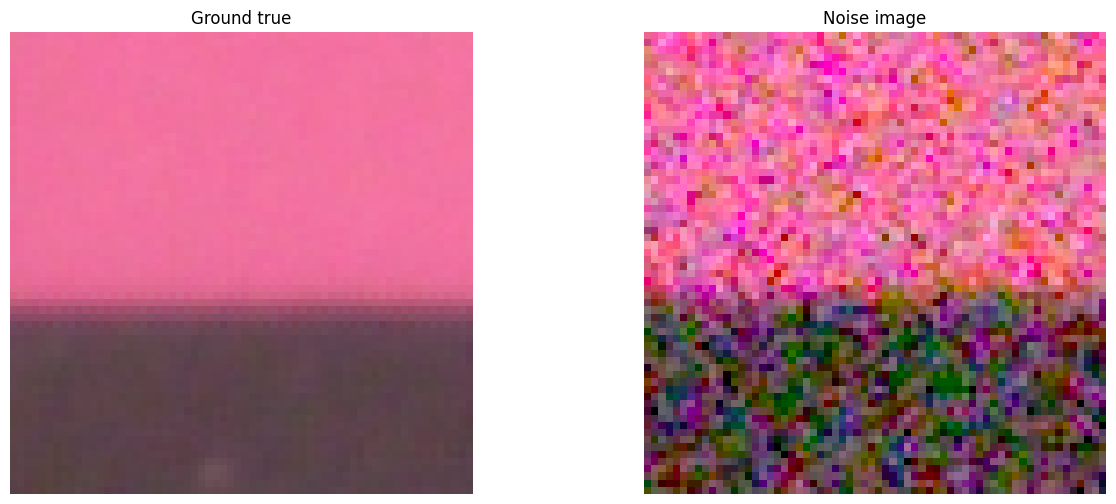

In [9]:
index = np.random.randint(0, len(gt_train))
print(index)
print(gt_train[index].shape)
plt.subplot(1, 2, 1), plt.imshow(gt_train[index])
plt.title('Ground true'), plt.axis(False)
plt.subplot(1, 2, 2), plt.imshow(noisy_train[index])
plt.title('Noise image'), plt.axis(False)

lets calculate PSNR and SSID metrics for ground true and noisy images. This is our key metrics that we try to increase

In [10]:
def calculate_key_metrics(gt_images, current_images, label):
    PSNR = 0
    SSID = 0
    for gt_image, noise_image in zip(gt_images, current_images):
        PSNR += psnr(gt_image, noise_image)
        SSID += ssim(gt_image, noise_image, channel_axis=2, data_range=noise_image.max() - noise_image.min())

    PSNR/=gt_images.shape[0]
    SSID/=current_images.shape[0]
    print(label + " average PSNR ->", PSNR)
    print(label + " average SSIM ->", SSID)
    


In [11]:
calculate_key_metrics(gt_train, noisy_train, 'train set')

train set average PSNR -> 28.121753138847605
train set average SSIM -> 0.34007607854584154


apply data generation technics for increasing training set

In [13]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train, y=gt_train, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test, y=gt_test, batch_size=BATCH_SIZE)

2023-03-31 16:40:15.709693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Build simple model

In [19]:
def build_model(input_size):
    inputs = x = layers.Input(shape=input_size + (3,))
    x = layers.Conv2D(16, 3, kernel_initializer='HeNormal', padding="same")(inputs)
    x = layers.Activation("relu")(x)
    
    u_layers = [x];
    #encoder part
    for filter in [32, 64, 128, 256]:
        x = layers.Conv2D(filter, 3, padding="same", kernel_initializer='HeNormal')(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filter, 3, padding="same", kernel_initializer='HeNormal')(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filter, 3, padding="same", kernel_initializer='HeNormal')(x)
        x = layers.Activation("relu")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        u_layers.append(x)

    #decoder part
    for filter_size in [128, 64, 32, 16]:
        if (len(u_layers)):
            u_layer = u_layers.pop()
            x = tf.keras.layers.add([u_layer, x])

        x = layers.Conv2DTranspose(filter_size, 3, strides=2, padding="same")(x)
        x = layers.Activation("relu")(x)

    x = tf.keras.layers.add([u_layers.pop(), x])
    x = Conv2D(3, kernel_size=(1,1), activation="sigmoid", padding="same")(x)       
    return Model(inputs, x)
        
autoencoder = build_model(INPUT_IMAGE_SIZE)
autoencoder.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 64, 64, 16)   448         ['input_4[0][0]']                
                                                                                                  
 activation_51 (Activation)     (None, 64, 64, 16)   0           ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)             (None, 64, 64, 32)   4640        ['activation_51[0][0]']          
                                                                                            

In [20]:
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,verbose=1,patience=2)
checkpoint_path = "training3/cp3.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0),
history = autoencoder.fit(
    noisy_train,
    gt_train,
    epochs=EPOTHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    verbose=1,
    callbacks=[cp_callback],
    validation_data=(noisy_test,gt_test),
)

Epoch 1/20
398/398 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 1: saving model to training3/cp3.ckpt
398/398 [==============================] - 648s 2s/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/20
398/398 [==============================] - ETA: 0s - loss: 8.2015e-04 - mean_squared_error: 8.2015e-04
Epoch 2: saving model to training3/cp3.ckpt
398/398 [==============================] - 601s 2s/step - loss: 8.2015e-04 - mean_squared_error: 8.2015e-04 - val_loss: 6.4357e-04 - val_mean_squared_error: 6.4357e-04
Epoch 3/20
398/398 [==============================] - ETA: 0s - loss: 6.2272e-04 - mean_squared_error: 6.2272e-04
Epoch 3: saving model to training3/cp3.ckpt
398/398 [==============================] - 597s 2s/step - loss: 6.2272e-04 - mean_squared_error: 6.2272e-04 - val_loss: 5.7213e-04 - val_mean_squared_error: 5.7213e-04
Epoch 4/20
398/398 [==========================

Train mse      0.00032751320395618677
Validation mse 0.0003133031423203647


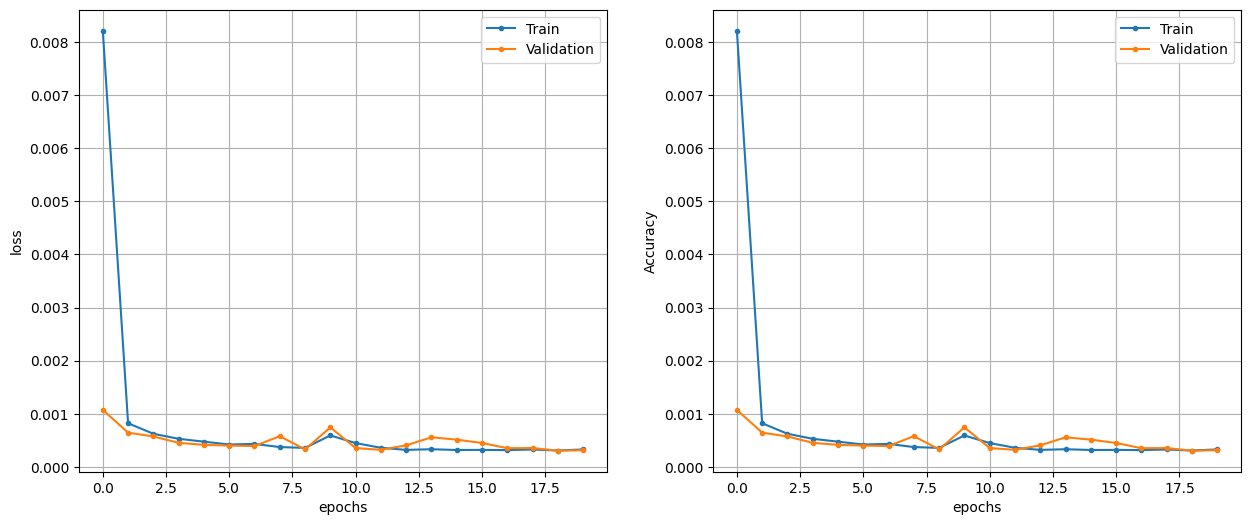

In [21]:
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['mean_squared_error'], '.-',
                           epochs, h['val_mean_squared_error'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train mse     ', h['mean_squared_error'][-1])
print('Validation mse', h['val_mean_squared_error'][-1])

In [22]:
predictions = autoencoder.predict(noisy_test)

398/398 [==============================] - 59s 147ms/step


In [25]:
calculate_key_metrics(gt_test, predictions, 'Predicted')
calculate_key_metrics(gt_test, noisy_test, 'Original')

/var/folders/zr/m75tnm4s4p1cj7v9pr8mtrdr0000gn/T/ipykernel_60342/3951283159.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  PSNR += psnr(gt_image, noise_image)


Predicted average PSNR -> 37.717340441400765
Predicted average SSIM -> 0.6340472287009995
Original average PSNR -> 28.07342638742183
Original average SSIM -> 0.3363503312511432


1462


(Text(0.5, 1.0, 'Denoised image'), (-0.5, 63.5, 63.5, -0.5))

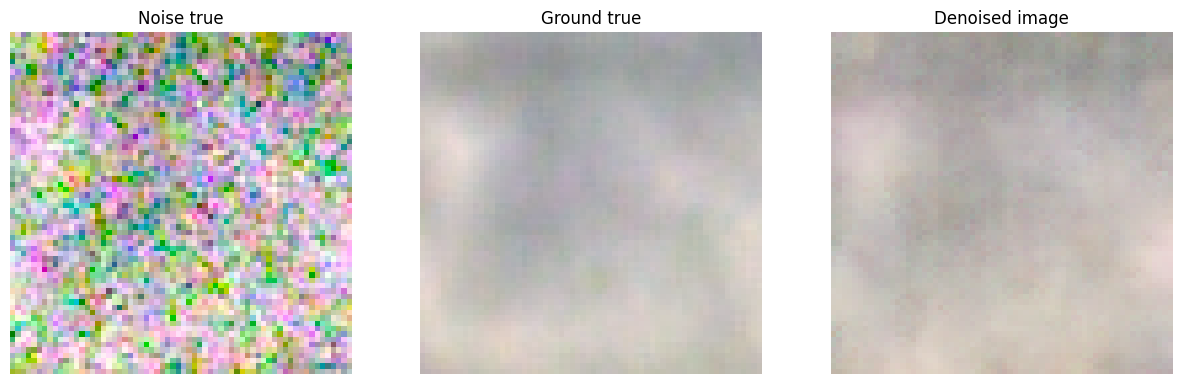

In [35]:
index = np.random.randint(0, len(noisy_test))
print(index)
plt.subplot(1, 3, 1), plt.imshow(noisy_test[index])
plt.title('Noise true'), plt.axis(False)
plt.subplot(1, 3, 2), plt.imshow(gt_test[index])
plt.title('Ground true'), plt.axis(False)
plt.subplot(1, 3, 3), plt.imshow(predictions[index])
plt.title('Denoised image'), plt.axis(False)


In [27]:
autoencoder.save('model_patches_64_bs_128_e_20_30_big_images_from_end_with_callbaks_2')

INFO:tensorflow:Assets written to: model_patches_64_bs_128_e_20_30_big_images_from_end_with_callbaks_2/assets


INFO:tensorflow:Assets written to: model_patches_64_bs_128_e_20_30_big_images_from_end_with_callbaks_2/assets
